## Step 1: Setup & Data Structures
We define strict Pydantic models for every node's output.

In [169]:
import os
import json
from typing import List, Optional, TypedDict
from pydantic import BaseModel, Field
from langchain_core.output_parsers import PydanticOutputParser
from langchain_core.prompts import PromptTemplate
from langgraph.graph import END, StateGraph
from langchain_community.vectorstores import FAISS
from langchain_huggingface import HuggingFaceEmbeddings
from langgraph.graph import StateGraph, START, END
from langchain_core.tools import tool
from langchain_text_splitters import RecursiveCharacterTextSplitter

from huggingface_hub import InferenceClient
from dotenv import load_dotenv
from pydantic import BaseModel, Field, field_validator, model_validator
from IPython.display import Image, display

In [170]:
# --- 1. Setup & Configuration (Kept Exact) ---
load_dotenv()

# Embeddings
embeddings = HuggingFaceEmbeddings(
    model_name="sentence-transformers/all-mpnet-base-v2",
    model_kwargs={"device": "cpu"},
    encode_kwargs={"normalize_embeddings": True}
)

# Vector DB
VECTOR_DB_PATH = "./vector_db/faiss_lmkr"
try:
    vectorstore = FAISS.load_local(VECTOR_DB_PATH, embeddings, allow_dangerous_deserialization=True)
    retriever = vectorstore.as_retriever(search_kwargs={"k": 5})
except:
    print("⚠️ DB not found, creating dummy for execution safety.")
    vectorstore = FAISS.from_texts(["LMKR founded in 1994. GVERSE is a software brand."], embeddings)
    retriever = vectorstore.as_retriever()

# LLM Client
hf_client = InferenceClient(
    model="mistralai/Mistral-7B-Instruct-v0.2",
    token=os.getenv("HF_API_TOKEN")
)

# --- 2. Pydantic Models for Structured Output ---

class QueryAugmentation(BaseModel):
    """Output for Node 1: Retrieval Augmentation"""
    augmented_queries: List[str] = Field(
        description="List of 3 alternative versions of the user question to improve search coverage."
    )

class GeneratedAnswer(BaseModel):
    """Output for Node 2: Generation"""
    answer: str = Field(description="The response to the user.")
    # FIX: Add default=[] so it doesn't crash if the model forgets this field
    sources_used: List[str] = Field(default=[], description="List of context chunks or titles used.")

    # FIX: Add a validator to try and rescue the sources if they are stuck inside the answer text
    @model_validator(mode='before')
    @classmethod
    def rescue_sources(cls, data):
        # If data is just a string (sometimes happens), wrap it
        if isinstance(data, str):
            return {"answer": data, "sources_used": []}
            
        # If 'sources_used' is missing but 'answer' mentions them, try to clean up
        if isinstance(data, dict):
            answer_text = data.get("answer", "")
            if "Sources Used:" in answer_text and "sources_used" not in data:
                # Basic cleanup to separate them (optional, but nice to have)
                parts = answer_text.split("Sources Used:")
                data["answer"] = parts[0].strip()
                # We won't try too hard to parse the list string, just prevent the crash
                data["sources_used"] = ["Mentioned in answer"]
                
        return data

    @field_validator('answer', mode='before')
    @classmethod
    def flatten_list_answer(cls, v):
        if isinstance(v, list):
            return ", ".join(map(str, v))
        return v
        
class ValidationResult(BaseModel):
    """Output for Node 3: Validation"""
    is_valid: bool = Field(description="True if context was used correctly and no hallucinations found.")
    reason: str = Field(description="Explanation of validation failure or success.")

# --- 3. State Definition ---

class AgentState(TypedDict):
    question: str
    context_chunks: List[str]
    generated_answer: Optional[GeneratedAnswer]
    validation: Optional[ValidationResult]
    retry_count: int

## Step 2: Helper for Mistral JSON Enforcement
Since Mistral can be chatty, this helper ensures we get clean JSON.

In [171]:
def query_llm_structured(prompt_text: str, parser: PydanticOutputParser) -> Optional[BaseModel]:
    format_instructions = parser.get_format_instructions()
    
    # FIX 1: Stronger prompt to stop it from returning the Schema Definition
    final_prompt = f"""{prompt_text}
    
    IMPORTANT INSTRUCTIONS:
    1. Output ONLY a valid JSON object. 
    2. Do NOT output the schema definition or "properties" block. Output the actual data instance.
    3. Do NOT escape underscores (e.g., use "sources_used", NOT "sources\\_used").
    
    {format_instructions}
    """
    
    try:
        messages = [{"role": "user", "content": final_prompt}]
        response = hf_client.chat_completion(
            messages=messages,
            max_tokens=500,
            temperature=0.1
        )
        json_str = response.choices[0].message.content.strip()
        
        # Clean Markdown wrapping
        if "```json" in json_str:
            json_str = json_str.split("```json")[1].split("```")[0].strip()
        elif "```" in json_str:
            json_str = json_str.split("```")[1].split("```")[0].strip()

        # FIX 2: Manually fix the "sources\_used" error common in Mistral models
        json_str = json_str.replace(r"\_", "_")

        # FIX 3: Detect if model returned a Schema instead of Data (Node 1 Fix)
        # If the JSON looks like {"properties": {...}, "type": "object"}, it failed.
        # We can try to salvage it or just return None to trigger a retry/fallback.
        try:
            data = json.loads(json_str)
            if "properties" in data and "type" in data and data.get("type") == "object":
                print("⚠️ Model returned schema instead of data. Retrying parse...")
                # Sometimes models put the answer inside 'default' or 'example' fields of the schema, 
                # but usually it's best to just fail and let the fallback handle it.
                return None
        except:
            pass # Not valid JSON yet, let the parser handle the error
            
        return parser.parse(json_str)

    except Exception as e:
        print(f"❌ JSON Parsing/API Failed: {e}")
        # print(f"Raw: {json_str}") # Uncomment for debugging
        return None

## Step 3: Define The Router and The 5 Nodes

### Extraction Tool

In [172]:

from typing import Literal
from selenium import webdriver
from selenium.webdriver.edge.options import Options as EdgeOptions
from bs4 import BeautifulSoup
import time
import requests
from langchain_core.tools import tool

# --- 1. Tool Extraction from scraping.py ---

def fetch_and_clean_body(url: str, depth=0) -> str:
    if depth > 1: return ""
    print(f"   🖥️ Booting Headless Edge for: {url}")
    
    edge_options = EdgeOptions()
    edge_options.add_argument("--headless")
    edge_options.add_argument("--no-sandbox")
    
    # FIX 1: Initialize variable to None OUTSIDE the try block
    driver = None 
    
    try:
        # FIX 2: Remove 'webdriver_manager'. Selenium 4.6+ downloads drivers automatically.
        # This fixes the "Could not reach host" error in many cases.
        driver = webdriver.Edge(options=edge_options)
        
        driver.get(url)
        time.sleep(5) 
        
        soup = BeautifulSoup(driver.page_source, "html.parser")
        
        # Cleanup tags
        for tag in soup(["nav", "footer", "script", "style", "noscript", "svg"]):
            tag.decompose()
            
        body = soup.find('body')
        if body:
            return body.get_text(separator="\n")
        else:
            return soup.get_text(separator="\n")
            
    except Exception as e:
        print(f"❌ Selenium Error: {e}")
        return ""
    finally:
        # FIX 3: Check if driver exists before quitting
        if driver:
            driver.quit()

def clean_text_content(text: str) -> str:
    lines = text.split("\n")
    cleaned_lines = []
    NOISE_PHRASES = ["warning", "required", "skip to content", "all rights reserved"]

    for line in lines:
        stripped = line.strip()
        if len(stripped) < 3: continue
        if any(phrase in stripped.lower() for phrase in NOISE_PHRASES): continue
        cleaned_lines.append(stripped)

    return "\n".join(cleaned_lines)

@tool
def scrape_contact_tool():
    """
    Scrapes the official LMKR contact page (https://lmkr.com/contact/) 
    to retrieve live addresses, phone numbers, and emails.
    """
    
    url = "https://lmkr.bamboohr.com/careers"
    print(f"🕸️ Tool Triggered: Dynamically scraping {url}...")
    
    raw_text = fetch_and_clean_body(url)
    clean_text = clean_text_content(raw_text)
    
    file_path = "live_contact_data.txt"
    with open(file_path, "w", encoding="utf-8") as f:
        f.write(f"SOURCE: {url}\n\n{clean_text}")
        
    return clean_text

@tool
def scrape_careers_tool():
    """
    Scrapes the official LMKR careers page (https://lmkr.com/careers/) 
    to retrieve live job openings, requirements, and application emails.
    """
    # Target the careers page
    url = "https://lmkr.bamboohr.com/careers"
    print(f"🕸️ Tool Triggered: Dynamically scraping {url}...")
    
    # Use your existing helper functions
    raw_text = fetch_and_clean_body(url)
    clean_text = clean_text_content(raw_text)

    file_path = "live_careers_data.txt"
    with open(file_path, "w", encoding="utf-8") as f:
        f.write(f"SOURCE: {url}\n\n{clean_text}")
    
    return clean_text

@tool
def scrape_news_fast_tool():
    """
    Scrapes the LMKR announcements page (https://lmkr.com/announcements) 
    using Requests + BS4 to retrieve the latest news and press releases.
    """
    url = "https://lmkr.com/announcements"
    print(f"🗞️ Tool Triggered: Fast scraping {url}...")
    
    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36"
    }
    
    try:
        response = requests.get(url, headers=headers, timeout=10)
        response.raise_for_status() 
        
        soup = BeautifulSoup(response.content, "html.parser")
        
        # Cleanup irrelevant tags
        for tag in soup(["nav", "footer", "script", "style", "noscript", "svg", "header"]):
            tag.decompose()
            
        body = soup.find('body')
        # Using the clean_text_content helper from your earlier cell
        clean_text = clean_text_content(body.get_text(separator="\n")) if body else ""
        
        # Save to file
        file_path = "live_news_data.txt"
        with open(file_path, "w", encoding="utf-8") as f:
            f.write(f"SOURCE: {url}\n\n{clean_text}")
            
        return clean_text

    except Exception as e:
        print(f"❌ Fast Scrape Error: {e}")
        return ""

In [173]:
# --- 2. New Router Data Model ---

class RouteDecision(BaseModel):
    """Router output model."""
    destination: Literal["career_retrieve_node", "retrieve_node", "news_retrieve_node", "conversational_node"] = Field(
        description="Choose 'news_retrieve_node' for announcements, press releases, or latest news about LMKR. Choose 'career_retrieve_node' for jobs/vacancies. Choose 'conversational_node' for chat. Choose 'retrieve_node' for everything else."
    )

### General Information Path

In [174]:
# --- 5. Nodes ---

def retrieve_node(state: AgentState):
    print("\n🔍 Node 1: Retrieve (Augmenting & Searching)...")
    question = state["question"]
    
    # --- ADAPTIVE LOGIC ---
    # Check if we are retrying. If so, widen the search scope.
    current_retry = state.get("retry_count", 0)
    base_k = 5
    
    # Increase k by 3 for every retry (e.g., 5 -> 8 -> 11)
    dynamic_k = base_k + (current_retry * 3) 
    
    if current_retry > 0:
        print(f"   🔄 Retry #{current_retry} detected: Expanding search context to top-{dynamic_k} chunks.")
    
    # 1. Multi-Query Augmentation
    parser = PydanticOutputParser(pydantic_object=QueryAugmentation)
    prompt = f"""
    User Question: {question}
    Task: Generate 3 different search query variations to find relevant info in a corporate vector DB.
    """
    structured_aug = query_llm_structured(prompt, parser)
    
    queries = [question]
    if structured_aug:
        queries.extend(structured_aug.augmented_queries)
        
    # 2. Retrieve & Deduplicate
    all_docs = []
    for q in queries:
        # UPDATED: Use vectorstore directly to enforce the dynamic 'k'
        # (retriever.invoke uses the fixed k=5 set at initialization)
        docs = vectorstore.similarity_search(q, k=dynamic_k)
        all_docs.extend([d.page_content for d in docs])
    
    # UPDATED: Slice using dynamic_k, not hardcoded [:5]
    # We use set() to remove exact duplicates from overlapping queries
    unique_context = list(set(all_docs))[:dynamic_k] 

    print (f"   Retrieved {len(unique_context)} unique context chunks (Target: {dynamic_k}).")
    
    # Debug log
    open("retrieved_context.txt", "w", encoding="utf-8").write("".join(unique_context))
    
    return {"context_chunks": unique_context}

# NODE 2: GENERATE (Safety & Context Focused)
def generate_node(state: AgentState):
    print("\n✍️ Node: Generate (Unified)...")
    
    question = state["question"]
    # Join the context chunks from EITHER retrieval path
    context_data = "\n---\n".join(state["context_chunks"])
    
    if not context_data:
        context_data = "No information found in the retrieved context."

    parser = PydanticOutputParser(pydantic_object=GeneratedAnswer)
    
    # --- UNIFIED PROMPT ---
    # This prompt works for both General QA and Job Listings
    prompt = f"""
    Context Data:
    {context_data}
    
    User Question: {question}
    
    Instructions:
    1. Answer the user's question using ONLY the provided Context Data.
    2. If the context contains a list of items (like job openings, software features, or locations), present them clearly as a list.
    3. If the answer is not in the context, state "I do not have enough information."
    4. Do not hallucinate. Maintain a professional tone.
    """
    
    structured_response = query_llm_structured(prompt, parser)
    
    # Fallback if generation fails
    if not structured_response:
        structured_response = GeneratedAnswer(
            answer="Error generating response.", 
            sources_used=["None"]
        )
        
    return {
        "generated_answer": structured_response, 
        "retry_count": state.get("retry_count", 0) + 1
    }
# NODE 3: VALIDATE (Hallucination & Structure Check)
def validate_node(state: AgentState):
    print("\n🛡️ Node 3: Robust Validation...")
    
    # Unpack state
    generation = state["generated_answer"]
    context_chunks = state["context_chunks"]
    context_text = "\n---\n".join(context_chunks)
    question = state["question"]
    
    # 1. Immediate Pass for Conversational/Fallbacks
    # If the answer acknowledges no info, we accept it (it's honest, not a hallucination)
    if "I do not have enough information" in generation.answer:
        return {
            "validation": ValidationResult(is_valid=True, reason="Honest fallback triggered.")
        }
        
    if "Conversational" in generation.sources_used:
         return {
            "validation": ValidationResult(is_valid=True, reason="Conversational turn.")
        }

    # 2. Stronger Validation Prompt
    parser = PydanticOutputParser(pydantic_object=ValidationResult)
    
    prompt = f"""
    You are a strict Quality Control Auditor.
    
    User Question: {question}
    Generated Answer: {generation.answer}
    
    Reference Context:
    {context_text}
    
    Instructions:
    1. Break the Generated Answer into individual claims.
    2. For EACH claim, attempt to find a supporting quote in the Reference Context.
    3. If a claim exists in the Answer but NOT in the Context, it is a HALLUCINATION.
    4. Ignore minor phrasing differences; look for semantic meaning.
    
    Output JSON:
    - set 'is_valid' to false if ANY unsupported claim is found.
    - set 'reason' to a specific explanation of what fact was unsupported.
    """
    
    # Reuse your existing helper
    validation = query_llm_structured(prompt, parser)
    
    if not validation:
        # If validator crashes, assume unsafe and force retry
        validation = ValidationResult(is_valid=False, reason="Validation LLM failed to parse.")
        
    print(f"   Evaluation: {'✅ PASS' if validation.is_valid else '❌ FAIL'} | Reason: {validation.reason}")
    
    return {"validation": validation}



### Router Node

In [175]:
# NODE 4: ROUTER 

def router_node(state: AgentState):
    print("\n🚦 Router: Analyzing User Intent...")
    question = state["question"]

    parser = PydanticOutputParser(pydantic_object=RouteDecision)
    prompt = f"""
    User Question: {question}
    
    Role: You are a Router. 
    Task: Decide where to send this query.
    
    Rules:
    1. If the user asks about News, Announcements, Press Releases, or Recent Updates about LMKR, route to 'news_retrieve_node'.
    2. If the user asks about Jobs, Careers, Vacancies, Internships about LMKR, route to 'career_retrieve_node'.
    3. If the user uses greetings (Hi, Hello) or generic chat or anything not related to LMKR, route to 'conversational_node'.
    4. For everything else (Company History, Software info, Contact, Services, Products), route to 'retrieve_node'.
    """
    
    decision = query_llm_structured(prompt, parser)
    
    # Default fallback
    if not decision:
        return {"destination": "retrieve_node"}
        
    print(f"   👉 Routing to: {decision.destination}")
    return {"destination": decision.destination}

### Basic Conversation

In [176]:
# --- NEW NODE: CONVERSATIONAL ---
def conversational_node(state: AgentState):
    print("\n💬 Node: Conversational (Direct LLM)...")
    question = state["question"]
    
    parser = PydanticOutputParser(pydantic_object=GeneratedAnswer)
    
    prompt = f"""
    User Input: {question}
    
    Instructions:
    1. You are a helpful corporate assistant for LMKR.
    2. Respond naturally to the greeting or conversational question.
    3. Do NOT make up technical facts. Just be polite.
    4. Set 'sources_used' to ["Conversational"].
    """
    
    structured_response = query_llm_structured(prompt, parser)
    
    # Fallback
    if not structured_response:
        structured_response = GeneratedAnswer(
            answer="Hello! I am the LMKR AI Assistant. How can I help you with our software or services?", 
            sources_used=["Conversational"]
        )
        
    # We return empty context_chunks to keep the state clean
    return {"generated_answer": structured_response, "context_chunks": []}

### Career Information Path

In [177]:
# --- NODE 1: CAREER RETRIEVE ---
def career_retrieve_node(state: AgentState):
    print("\n💼 Node: Career Retrieve (Adaptive)...")
    question = state["question"]
    current_retry = state.get("retry_count", 0)
    
    # ADAPTIVE LOGIC: Widen search on retries
    base_k = 4
    dynamic_k = base_k + (current_retry * 4) # 4 -> 8 -> 12
    
    # We need a persistent way to hold the vectorstore between retries.
    # In a stateless graph, we usually rebuild it from the raw text in 'state' or re-scrape.
    # To keep this simple and robust:
    
    # 1. CHECK FOR EXISTING CONTEXT (Avoid Re-scraping if possible)
    # If we are retrying, we might want to rely on previously scraped text if available.
    # However, since 'context_chunks' holds the *selected* chunks, we likely need the full raw text.
    # For this implementation, we will re-run the tool if it's the first run, 
    # but strictly rely on a broader search if we are looping back.
    
    raw_text = ""
    
    # Optimization: You could store 'full_scraped_text' in AgentState to avoid calling the tool again.
    # For now, we will call the tool only if we don't have a cache mechanism, 
    # but typically you don't want to re-scrape in a loop.
    
    # Simulating a check: If we are in a retry loop, we assume the previous scrape was valid 
    # but we missed the relevant chunk. 
    # NOTE: Since the tool writes to a file, we can read that file on retry instead of hitting the web.
    
    if current_retry > 0 and os.path.exists("live_careers_data.txt"):
        print(f"   🔄 Retry #{current_retry}: Reading cached career data (Skipping Web Scrape)...")
        with open("live_careers_data.txt", "r", encoding="utf-8") as f:
            raw_text = f.read()
    else:
        # First run or file missing -> Active Scrape
        raw_text = scrape_careers_tool.invoke({})

    if not raw_text:
        print("   ⚠️ Warning: Scrape returned empty data.")
        return {"context_chunks": []}

    # 2. Chunk & Index (Re-building index is fast for small text)
    text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50)
    chunks = text_splitter.split_text(raw_text)
    
    temp_vectorstore = FAISS.from_texts(chunks, embeddings)
    
    # 3. Dynamic Search
    print(f"   Searching career data with k={dynamic_k}...")
    retrieved_docs = temp_vectorstore.similarity_search(question, k=dynamic_k)
    retrieved_texts = [doc.page_content for doc in retrieved_docs]
    
    print(f"   Retrieved {len(retrieved_texts)} relevant career chunks.")
    return {"context_chunks": retrieved_texts}

# --- NODE 2: CAREER GENERATE ---
def career_generate_node(state: AgentState):
    print("\n✍️ Node: Career Generate...")
    
    question = state["question"]
    context_data = "\n---\n".join(state["context_chunks"])
    
    if not context_data:
        context_data = "No specific job openings found."

    parser = PydanticOutputParser(pydantic_object=GeneratedAnswer)
    
    prompt = f"""
    Context (Live Job Board Data):
    {context_data}
    
    User Question: {question}
    
    Instructions:
    1. ANALYZE the Context Data first. Does it contain specific job titles (e.g., "Software Engineer", "Geophysicist")?
    2. If the Context Data only contains generic company info ("rewarding place to work", "benefits") but NO specific job titles, you MUST output: "I could not retrieve the live job list at this time."
    3. If valid jobs are listed, answer the user's question.
    4. WARNING: Do not invent job titles. Do not list jobs that are not explicitly in the text above.
    """
    
    structured_response = query_llm_structured(prompt, parser)
    
    # Fallback
    if not structured_response:
        structured_response = GeneratedAnswer(
            answer="I checked the careers page but couldn't parse the listings.", 
            sources_used=["https://lmkr.com/careers/"]
        )
        
    current_retries = state.get("retry_count", 0)
    return {"generated_answer": structured_response, "retry_count": current_retries + 1}

### News/ Announcements Path

In [178]:
# --- NEW NODE: NEWS RETRIEVE ---
def news_retrieve_node(state: AgentState):
    print("\n🗞️ Node: News Retrieve (Fast & Adaptive)...")
    question = state["question"]
    current_retry = state.get("retry_count", 0)
    
    # Adaptive Logic: Widen search on retries
    base_k = 4
    dynamic_k = base_k + (current_retry * 4) 
    
    raw_text = ""
    
    # Check cache to avoid re-requesting if looping
    if current_retry > 0 and os.path.exists("live_news_data.txt"):
        print(f"   🔄 Retry #{current_retry}: Reading cached news data...")
        with open("live_news_data.txt", "r", encoding="utf-8") as f:
            raw_text = f.read()
    else:
        # First run -> Active Fast Scrape
        raw_text = scrape_news_fast_tool.invoke({})

    if not raw_text:
        print("   ⚠️ Warning: News scrape returned empty data.")
        return {"context_chunks": []}

    # Chunk & Index into Temporary Vector Store
    text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50)
    chunks = text_splitter.split_text(raw_text)
    
    if not chunks:
         return {"context_chunks": []}
         
    temp_vectorstore = FAISS.from_texts(chunks, embeddings)
    
    # Search
    print(f"   Searching news data with k={dynamic_k}...")
    retrieved_docs = temp_vectorstore.similarity_search(question, k=dynamic_k)
    retrieved_texts = [doc.page_content for doc in retrieved_docs]
    
    print(f"   Retrieved {len(retrieved_texts)} relevant news chunks.")
    
    # Return chunks to the SHARED state (so Generate Node can use them)
    return {"context_chunks": retrieved_texts}

## Step 4: Build Graph & Logic

In [179]:
# --- 6. Edge Logic ---

def router(state: AgentState):
    validation = state["validation"]
    retry_count = state.get("retry_count", 0)
    
    # 1. If Valid, End
    if validation and validation.is_valid:
        print("✅ Validation Passed.")
        return END
    
    # 2. If Max Retries, End
    if retry_count >= 2:
        print("🛑 Max retries reached. Returning best effort.")
        return END
        
    # 3. Validation Failed - Decide where to loop back to
    print(f"🔄 Validation Failed: {validation.reason if validation else 'Unknown'}. Regenerating...")
    
    # Check which path we were on
    current_path = state.get("destination")
    
    if current_path == "contact_retrieve_node":
        return "contact_generate_node"
    else:
        return "generate_node" # Retry standard RAG generation

def validation_router(state: AgentState):
    validation = state["validation"]
    retry_count = state.get("retry_count", 0)
    # We need to know where we came from to know where to go back to
    destination = state.get("destination", "retrieve_node") 

    # 1. Success
    if validation and validation.is_valid:
        return END
    
    # 2. Max Retries
    if retry_count >= 2:
        print("🛑 Max retries reached. Returning best effort.")
        return END
        
    # 3. FAILURE -> LOOP BACK
    print(f"🔄 Validation Failed: {validation.reason}. Expanding search context...")
    
    if destination == "career_retrieve_node":
        return "career_retrieve_node"
    elif destination == "news_retrieve_node":   # <--- HANDLE NEWS LOOP
        return "news_retrieve_node"
    elif destination == "conversational_node":
        return "conversational_node"
    else:
        return "retrieve_node"

### Workflow formation

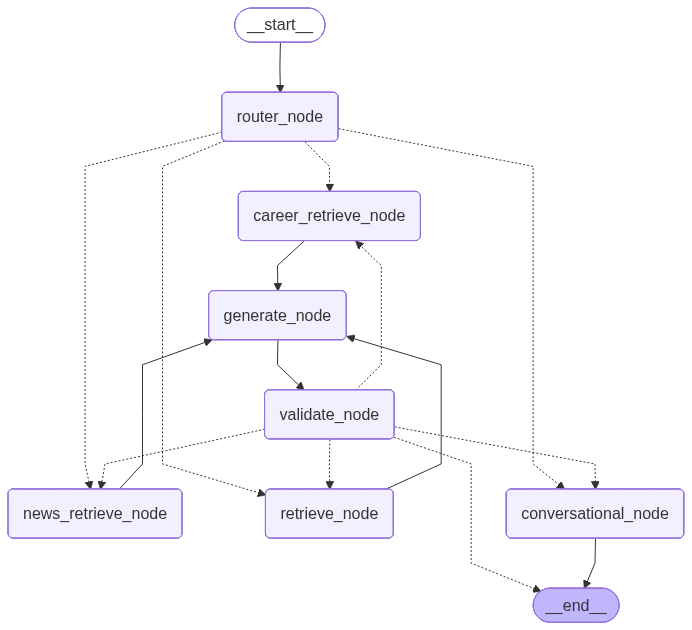

In [180]:
workflow = StateGraph(AgentState)

# Add Nodes
workflow.add_node("router_node", router_node)
workflow.add_node("career_retrieve_node", career_retrieve_node)
workflow.add_node("news_retrieve_node", news_retrieve_node) # <--- ADD NODE
workflow.add_node("retrieve_node", retrieve_node)
workflow.add_node("conversational_node", conversational_node)
workflow.add_node("generate_node", generate_node) 
workflow.add_node("validate_node", validate_node)

# Entry
workflow.set_entry_point("router_node")

# Conditional Edges from Router
workflow.add_conditional_edges(
    "router_node",
    lambda x: x["destination"],
    {
        "career_retrieve_node": "career_retrieve_node",
        "news_retrieve_node": "news_retrieve_node", # <--- ADD EDGE
        "retrieve_node": "retrieve_node",
        "conversational_node": "conversational_node"
    }
)

# Connect Retrieval Nodes to Generator
workflow.add_edge("career_retrieve_node", "generate_node")
workflow.add_edge("news_retrieve_node", "generate_node") # <--- ADD EDGE
workflow.add_edge("retrieve_node", "generate_node")

# Generator -> Validator
workflow.add_edge("generate_node", "validate_node")

# Conditional Edges from Validator (The Loop)
workflow.add_conditional_edges(
    "validate_node",
    validation_router, 
    {
        END: END,
        "retrieve_node": "retrieve_node",             
        "career_retrieve_node": "career_retrieve_node", 
        "news_retrieve_node": "news_retrieve_node", # <--- ADD LOOP BACK
        "conversational_node": "conversational_node"
    }
)

workflow.add_edge("conversational_node", END)

app = workflow.compile()
# Visualize
display(Image(app.get_graph().draw_mermaid_png()))

## Step 5: Execution

In [ ]:
# --- 8. Execution Test ---

print("🚀 Starting RAG Pipeline (Retrieve -> Generate -> Validate)...")
import urllib3
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

initial_state = {
    "question": "Latest news about LMKR", 
    "retry_count": 0,
    "context_chunks": [],
    "generated_answer": None,
    "validation": None
}

final_state = app.invoke(initial_state)

print("\n Query: ", initial_state["question"])
print("\n🎉 Final Result:")
if final_state.get('generated_answer'):
    print(f"Answer: {final_state['generated_answer'].answer}")
    
    # FIX: Check if validation actually ran
    if final_state.get('validation'):
        status = 'Pass' if final_state['validation'].is_valid else 'Fail (Max Retries)'
        print(f"Validation Status: {status}")
    else:
        print("Validation Status: N/A (Direct Contact Route)")
        
    print(f"Source chunks Used: {final_state['generated_answer'].sources_used}")
else:
    print("Process failed to generate an answer.")

🚀 Starting RAG Pipeline (Retrieve -> Generate -> Validate)...

🚦 Router: Analyzing User Intent...
   👉 Routing to: news_retrieve_node

🗞️ Node: News Retrieve (Fast & Adaptive)...
🗞️ Tool Triggered: Fast scraping https://lmkr.com/announcements...
   Searching news data with k=4...
   Retrieved 4 relevant news chunks.

✍️ Node: Generate (Unified)...
